<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.ops.parallel_for.gradients import jacobian
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
np.indices((2,2))

array([[[0, 0],
        [1, 1]],

       [[0, 1],
        [0, 1]]])

In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [5]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [0]:
tf.reset_default_graph()

batch_size  = 256
hidden_size = 8

def inference(in_net):
    with tf.variable_scope('generator/inference', reuse=tf.AUTO_REUSE):
        net = tf.layers.dense(in_net, 512, name='dense_1', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 256, name='dense_3', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 2*hidden_size, name='dense_5', activation=None)
    return net

def generator(in_net):
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
        net = tf.layers.dense(in_net, 256, name='dense_1', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 512, name='dense_3', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 784, name='dense_5', activation=None)
    return net

lr    = tf.placeholder_with_default(0.001,shape=[])

x     = tf.placeholder(shape=[batch_size, 784], dtype=tf.float32)

prior = tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0)

mu, sigma        = tf.split(inference(x), 2, axis=-1)
sigma            = tf.nn.softplus(sigma) + 0.0001
approx_posterior = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

z = approx_posterior.sample()

sample_size = tf.placeholder_with_default(100,shape=[])

z_samples   = approx_posterior.sample(sample_size)

x_samples   = tfd.Independent(tfd.Bernoulli(logits=generator(z_samples))).sample(sample_size)

x_sims      = tfd.Independent(tfd.Bernoulli(logits=generator( prior.sample(batch_size)))).sample(sample_size)

data_likelihood = tfd.Independent(tfd.Bernoulli(logits=generator(z)))

kl_divergence   = tfd.kl_divergence(approx_posterior, prior)

shape1a         = tf.shape(data_likelihood.log_prob(x))

shape2a         = tf.shape(kl_divergence)

elbo            = - tf.reduce_mean(data_likelihood.log_prob(x) - kl_divergence,axis=0)

with tf.variable_scope("posterior2"):
    mu_t = tf.Variable(initial_value=np.zeros((batch_size,hidden_size)), dtype=tf.float32)
    sigma_t = tf.Variable(initial_value=np.ones((batch_size,hidden_size *(hidden_size +1) // 2)), dtype=tf.float32)
sigma_t2 = tfd.matrix_diag_transform(tfd.fill_triangular(sigma_t), transform=tf.nn.softplus)

approx_posterior2 = tfd.MultivariateNormalTriL(loc=mu_t,scale_tril=sigma_t2, name='posterior2')

z2                = approx_posterior2.sample()

zmean             = approx_posterior2.mean()

likeli_zmean      = tfd.Independent(tfd.Bernoulli(logits=generator(zmean)))

kl_divergence2    = tfd.kl_divergence(approx_posterior2, prior) 

shape1            = tf.shape(kl_divergence2)

mymask            = tf.placeholder_with_default(np.ones((784),dtype=int),shape=[784])

shape6            = tf.shape(generator(z2))

liklogits         = tf.boolean_mask(generator(z2), mymask, axis=1)

shape2            = tf.shape(liklogits)

data_likelihood2  = tfd.Independent(tfd.Bernoulli(logits=liklogits))

masked_x          = tf.boolean_mask(x, mymask, axis=1)

shape3            = tf.shape(masked_x)

shape4            = tf.shape(data_likelihood2.log_prob(masked_x))
    
elbo2             = -tf.reduce_mean(data_likelihood2.log_prob(masked_x)- kl_divergence2,axis=0)

shape5            = tf.shape(elbo2)

z2_samples        = approx_posterior2.sample(sample_size)

x2_samples        = tfd.Independent(tfd.Bernoulli(logits=generator(z2_samples))).sample(sample_size)

In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=5,zoom_range=0.1)
#datagen.fit(x_train.reshape((50000,28,28,1))) only needed if data trafos depend on the data itself

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
opt_op = optimizer.minimize(elbo)

opt_op2 = optimizer.minimize(elbo2,var_list=[mu_t,sigma_t])

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
losses_data = []

In [119]:
imgsv_full= x_valid.reshape((-1,28,28,1))
print(imgsv_full.shape)

(10000, 28, 28, 1)


In [120]:
nepochs     = 20
jj          = 0.
lrate_start = 1e-3
maxcount    = 10
ii          = 0

for ep in range(nepochs):
    gen  = datagen.flow(x_train.reshape((50000,28,28,1)), batch_size=batch_size)
    
    count = 0
    print('new epoch')
    lrate=lrate_start
    for i in range(50000 // batch_size):
        # Train the inference model
        imgs  = next(gen)

        imgsv = imgsv_full[ii*batch_size:(ii+1)*batch_size]

        if (len(imgsv) < batch_size) or ((ii+1)*batch_size==len(imgsv_full)):
          ii=0
          imgsv = imgsv_full[ii*batch_size:(ii+1)*batch_size]
        ii+=1
       
        
        if len(imgs) < batch_size:
            imgs = next(gen)

            
        imgs = imgs.reshape([-1,784])
        imgsv= imgsv.reshape([-1,784])

        # Train the generative model
        _, l  = sess.run([opt_op, elbo], feed_dict={x: imgs, lr:lrate})
        lv    = sess.run([elbo], feed_dict={x: imgsv})[0]
        
        if lv>l:
          jj+=1
        if l>lv:
          jj=0.
        
      
        losses_data.append(l)
        
        count += 1
        if count % 10 ==0:
            print(ep, l, lv, jj)
            
        if jj>maxcount:
            print('break criterion met')
            break
    if jj>(maxcount+5):
      break

new epoch
0 242.73761 231.11633 0.0
0 208.69272 213.94669 1.0
0 205.28975 206.30519 1.0
0 201.44467 189.75975 0.0
0 201.23181 188.32642 0.0
0 201.61536 186.54843 0.0
0 194.78023 185.27232 0.0
0 192.6661 187.17186 0.0
0 188.38046 181.24515 0.0
0 183.19601 173.34265 0.0
0 176.29068 167.43771 0.0
0 176.66113 166.02258 0.0
0 160.23608 155.64204 0.0
0 166.60484 156.48273 0.0
0 156.83469 160.13257 1.0
0 160.86893 141.49124 0.0
0 157.99326 148.3199 0.0
0 163.55438 145.48535 0.0
0 155.40143 139.09686 0.0
new epoch
1 149.85054 138.9939 0.0
1 156.0098 143.81516 0.0
1 149.58902 143.01059 0.0
1 148.02017 135.56787 0.0
1 153.01657 134.72379 0.0
1 149.24455 131.91293 0.0
1 145.0093 136.66164 0.0
1 142.52914 140.99503 0.0
1 148.42308 139.77309 0.0
1 141.11145 134.83011 0.0
1 142.2324 133.03581 0.0
1 145.1271 135.83011 0.0
1 144.94089 130.88634 0.0
1 140.15512 133.14235 0.0
1 142.97403 137.83649 0.0
1 134.76353 123.10007 0.0
1 139.15764 129.42114 0.0
1 138.75209 127.89705 0.0
1 146.41547 123.0304 0.0


KeyboardInterrupt: ignored

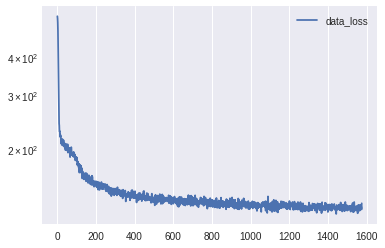

In [121]:
plot(losses_data,label='data_loss')
legend()
yscale('log')

In [0]:
res    = sess.run(z, feed_dict={x: x_test[0:batch_size]})
labels = targets_test[0:batch_size]

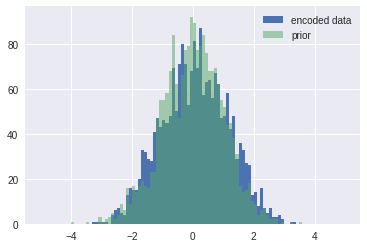

In [123]:
hist(res.flatten(),100,range=[-5,5],label='encoded data');
hist(randn(len(res.flatten())),100,range=[-5,5],alpha=0.5,label='prior');
legend()

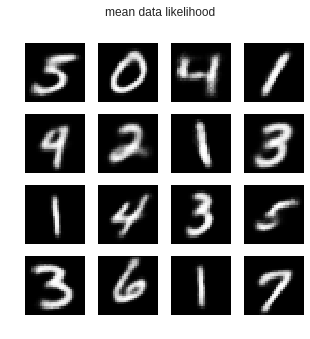

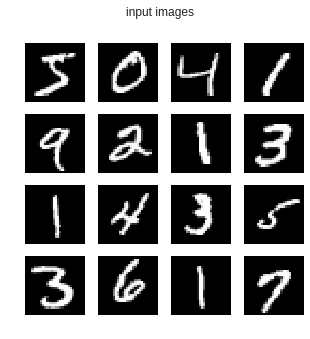

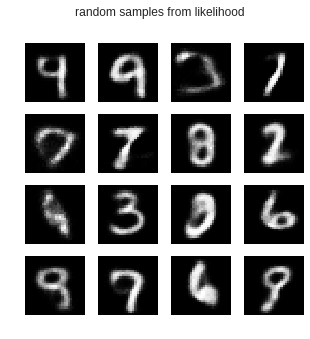

In [124]:
res, inim, s = sess.run([data_likelihood.mean(), x, x_sims], feed_dict={x: x_train[0:batch_size], sample_size: 400})
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(16):
    subplot(4,4,i+1)
    imshow((res )[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
figure(figsize=(5,5))
suptitle('input images')
for i in range(16):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('random samples from likelihood')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(s[:,i,:].reshape((-1,28,28)),axis=0),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:
mask = np.ones(IMAGE_SHAPE, dtype=int)
#mask[0:12,0:12]=0
mask = mask.reshape((28*28))

mask = np.asarray([mask]*batch_size)
#print(mask.shape)
masked_data = x_valid[0:batch_size]*mask

mask = np.ones(IMAGE_SHAPE, dtype=int)
#mask[0:12,0:12]=0
mask = mask.reshape((28*28))

In [126]:
#_, ll = sess.run([opt_op2, elbo2], feed_dict={x: masked_data, lr:lrate})
print(sess.run([shape1a,shape2a,shape6], feed_dict={x: masked_data, lr:lrate, mymask:mask}))
sess.run([shape1,shape2,shape3,shape4,shape5], feed_dict={x: masked_data, lr:lrate, mymask:mask})

[array([256], dtype=int32), array([256], dtype=int32), array([256, 784], dtype=int32)]


[array([256], dtype=int32),
 array([256, 784], dtype=int32),
 array([256, 784], dtype=int32),
 array([256], dtype=int32),
 array([], dtype=int32)]

In [0]:
posterior2_loss=[]

In [129]:
lrate=1e-2
for ii in range(1000):
  _, ll = sess.run([opt_op2, elbo2], feed_dict={x: masked_data, lr:lrate, mymask:mask})
  posterior2_loss.append(ll)
  if ii%100==0:
    mus, sigmas = sess.run([mu_t, sigma_t], feed_dict={x: masked_data})
    print(mus[0:10])
  print(ll)

[[-1.06205499e+00  4.66314137e-01  5.71330845e-01 -3.50580901e-01
   5.55084169e-01  1.16672921e+00 -4.95789856e-01 -9.65265706e-02]
 [-1.26184142e+00  1.30784857e+00 -8.75477374e-01 -1.43907857e+00
  -1.00449428e-01  2.42612973e-01  2.83010513e-01  1.34828770e+00]
 [ 1.51096082e+00  1.74453592e+00  5.63863814e-01 -1.02320266e+00
  -1.26051056e+00 -1.02072346e+00 -2.31687889e-01 -5.46396017e-01]
 [ 4.37112331e-01  1.15523100e+00  1.40288270e+00 -7.72572696e-01
   6.54815674e-01 -1.97789228e+00  2.41033030e+00  3.21324289e-01]
 [-7.23626278e-03  1.94455326e+00 -8.41266096e-01 -9.52817023e-01
   1.60281539e-01 -1.22154045e+00 -7.69471049e-01 -4.11943793e-01]
 [ 6.68576837e-01  2.25243306e+00  2.03577250e-01  5.81708610e-01
   1.52134430e-02  1.25156541e-03  1.26923037e+00  6.08260572e-01]
 [ 5.27389646e-01 -1.70871770e+00 -3.44027233e+00  1.44686842e+00
  -4.58542168e-01  5.38014591e-01  4.59748209e-01  3.52901459e-01]
 [-1.57183731e+00  9.48343337e-01  5.55456042e-01 -5.68915606e-01
   

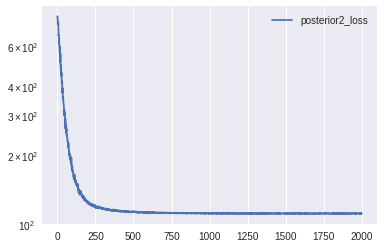

In [130]:
plot(posterior2_loss,label='posterior2_loss')
legend()
yscale('log')

In [0]:
res2 = sess.run(z2, feed_dict={x: masked_data[0:batch_size]})
res = sess.run(z, feed_dict={x: masked_data[0:batch_size]})

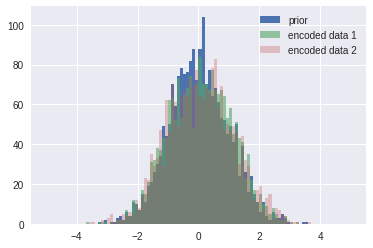

In [132]:
hist(randn(len(res.flatten())),100,range=[-5,5],label='prior');
hist(res.flatten(),100,range=[-5,5],alpha=0.6,label='encoded data 1');
hist(res2.flatten(),100,range=[-5,5],alpha=0.3,label='encoded data 2');
legend()

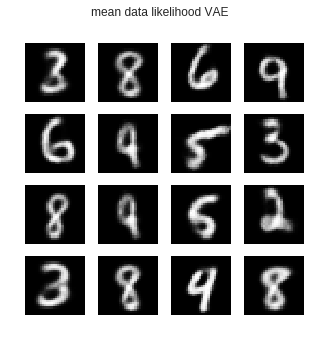

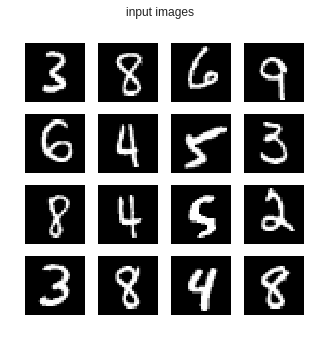

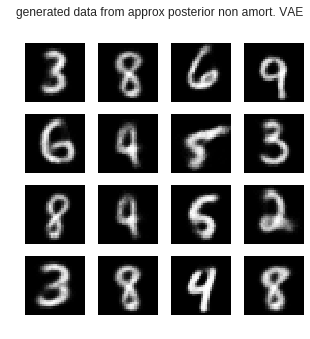

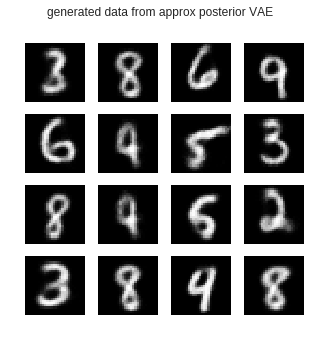

In [133]:
inim, xrecons2 = sess.run([x, x2_samples], feed_dict={x: masked_data[0:batch_size], sample_size: 20})
xmean, xrecon          = sess.run([data_likelihood.mean(),x_samples], feed_dict={x: masked_data[0:batch_size], sample_size: 20})


figure(figsize=(5,5))
suptitle('mean data likelihood VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow((xmean)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')


# figure(figsize=(5,5))
# suptitle('mean data likelihood non amortized VAE')
# for i in range(16):
#     subplot(4,4,i+1)
#     imshow((res2)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
#     axis('off')


figure(figsize=(5,5))
suptitle('input images')
for i in range(16):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

    
figure(figsize=(5,5))
suptitle('generated data from approx posterior non amort. VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xrecons2[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
figure(figsize=(5,5))
suptitle('generated data from approx posterior VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xrecon[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:
#has already been trained on one specific data set
data_from_mean_z = sess.run(likeli_zmean.mean(), feed_dict={x: masked_data[0:batch_size], mymask:mask, sample_size: 20})

(256, 784)


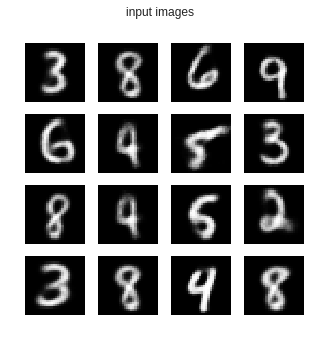

In [136]:
print(data_from_mean_z.shape)
figure(figsize=(5,5))
suptitle('input images')
for i in range(16):
    subplot(4,4,i+1)
    imshow(data_from_mean_z[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')


In [137]:
mask = np.ones(IMAGE_SHAPE, dtype=int)
mask[6:14,0:28]=0
mask = mask.reshape((28*28))

mask = np.asarray([mask]*batch_size)
print(mask.shape)
masked_data = x_valid[0:batch_size]*mask

mask = np.ones(IMAGE_SHAPE, dtype=int)
mask[6:14,0:28]=0
mask = mask.reshape((28*28))

(256, 784)


In [141]:
lrate=1e-2
for ii in range(1000):
  _, ll = sess.run([opt_op2, elbo2], feed_dict={x: masked_data, lr:lrate, mymask:mask})
  posterior2_loss.append(ll)
  if ii%100==0:
    mus, sigmas = sess.run([mu_t, sigma_t], feed_dict={x: masked_data, mymask:mask})
    print(mus[0:10])
  print(ll)

[[-1.0474024   0.52338845  0.5949422  -0.34823397  0.5560027   1.0913174
  -0.47332066 -0.12184178]
 [-1.2673969   1.3059385  -0.88418645 -1.3565693  -0.12668134  0.23944108
   0.2654715   1.2856654 ]
 [ 1.5307142   1.7314552   0.5560049  -0.98953193 -1.2634192  -0.99859273
  -0.20964059 -0.60273665]
 [ 0.51204306  1.1896449   1.4888327  -0.8165484   0.61181325 -1.9498332
   2.4481678   0.25689325]
 [-0.02351082  1.8942304  -0.80031323 -0.9329027   0.12791972 -1.2218987
  -0.80923146 -0.39245418]
 [ 0.6321306   2.216655    0.14751114  0.5765461   0.01892885  0.05221826
   1.3046118   0.5609653 ]
 [ 0.50912404 -1.7146658  -3.4065914   1.474641   -0.41283756  0.5224751
   0.4402983   0.37124455]
 [-1.5717046   0.9191852   0.6090809  -0.5776099   0.67667335  0.24884267
  -0.49994943 -1.5069828 ]
 [-0.5481648   0.57182324  0.26720044 -1.4361677  -1.1851199   0.73452044
   0.6059903   0.9618369 ]
 [ 0.61913735  1.8576065   0.46226206  0.44562146  0.24170059  0.10488611
   1.2348229   0.5465

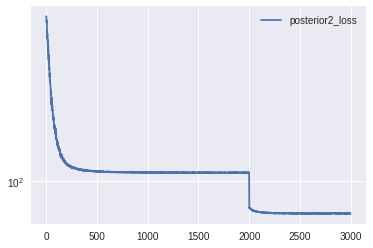

In [142]:
plot(posterior2_loss,label='posterior2_loss')
legend()
yscale('log')

In [0]:
res3 = sess.run(z2, feed_dict={x: masked_data[0:batch_size]})
#res = sess.run(z, feed_dict={x: masked_data[0:batch_size]})

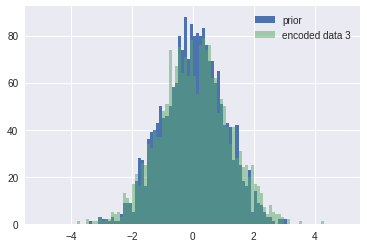

In [145]:
hist(randn(len(res3.flatten())),100,range=[-5,5],label='prior');
hist(res3.flatten(),100,range=[-5,5],alpha=0.5,label='encoded data 3');
legend()

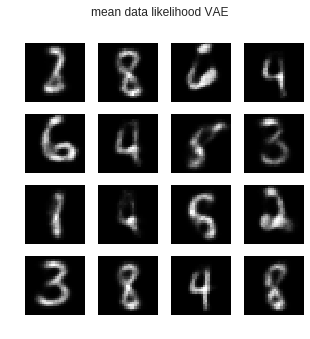

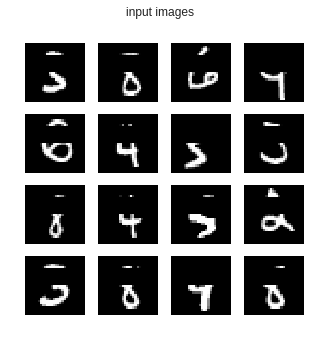

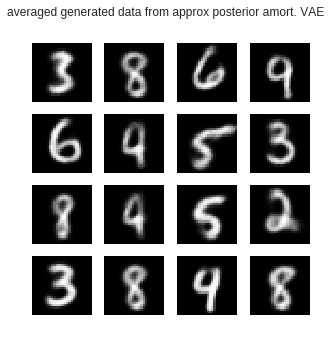

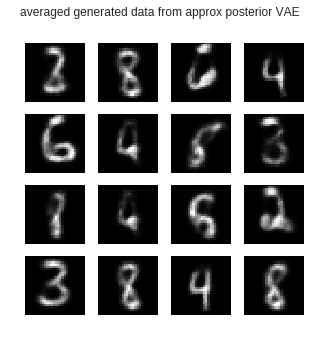

In [147]:
inim, xrecons2 = sess.run([x, x2_samples], feed_dict={x: masked_data[0:batch_size], sample_size: 40})
xmean, xrecon          = sess.run([data_likelihood.mean(),x_samples], feed_dict={x: masked_data[0:batch_size], sample_size: 40})

figure(figsize=(5,5))
suptitle('mean data likelihood VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow((xmean)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')


# figure(figsize=(5,5))
# suptitle('mean data likelihood amortized VAE')
# for i in range(16):
#     subplot(4,4,i+1)
#     imshow((res2)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
#     axis('off')


figure(figsize=(5,5))
suptitle('input images')
for i in range(16):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

    
figure(figsize=(5,5))
suptitle('averaged generated data from approx posterior amort. VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xrecons2[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
figure(figsize=(5,5))
suptitle('averaged generated data from approx posterior VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xrecon[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')